In [1]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit import Chem
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
from itertools import chain

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# other packages
import pandas as pd
import numpy as np
import gzip
import csv
import re

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.error')

In [2]:
similarity_matrix = np.load('../data/similarity_matrix.npy')


In [3]:
distance_matrix = 1 - similarity_matrix


In [4]:
distance_matrix

array([[0.        , 0.62893082, 0.59285714, ..., 0.89864865, 0.84444444,
        0.94117647],
       [0.62893082, 0.        , 0.69375   , ..., 0.85620915, 0.84931507,
        0.91666667],
       [0.59285714, 0.69375   , 0.        , ..., 0.89208633, 0.824     ,
        0.9453125 ],
       ...,
       [0.89864865, 0.85620915, 0.89208633, ..., 0.        , 0.85858586,
        0.93684211],
       [0.84444444, 0.84931507, 0.824     , ..., 0.85858586, 0.        ,
        0.89411765],
       [0.94117647, 0.91666667, 0.9453125 , ..., 0.93684211, 0.89411765,
        0.        ]])

In [4]:
# load dataset
suppl = Chem.SDMolSupplier("../data/drugbank.sdf")
drug_bank = [[mol, 'drugbank'] for mol in suppl if mol]

with gzip.open("../data/actives_final.sdf.gz") as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'acives'] for mol in supp_actives if mol]

with gzip.open("../data/decoys_final.sdf.gz") as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

In [5]:
# create pandas dataframe and concatenate all data
df = pd.DataFrame(drug_bank + actives + decoys, columns=['mol', 'source'])

In [7]:
df

,mol,label
0,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e21f0>,drugbank
1,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e2260>,drugbank
2,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e22d0>,drugbank
3,<rdkit.Chem.rdchem.Mol object at 0x7f4a7c1d9c40>,drugbank
4,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e2340>,drugbank
...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9c40>,decoys
42178,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9cb0>,decoys
42179,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9d20>,decoys
42180,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9d90>,decoys


In [6]:
# new smiles column
df['smiles'] = df['mol'].apply(Chem.MolToSmiles)

In [7]:
# new MQN column
df['MQN'] = df['mol'].apply(rdMolDescriptors.MQNs_)

In [8]:
#  normalize MQN values
df['MQN'] = df['MQN'].apply(lambda x: x / np.linalg.norm(x))

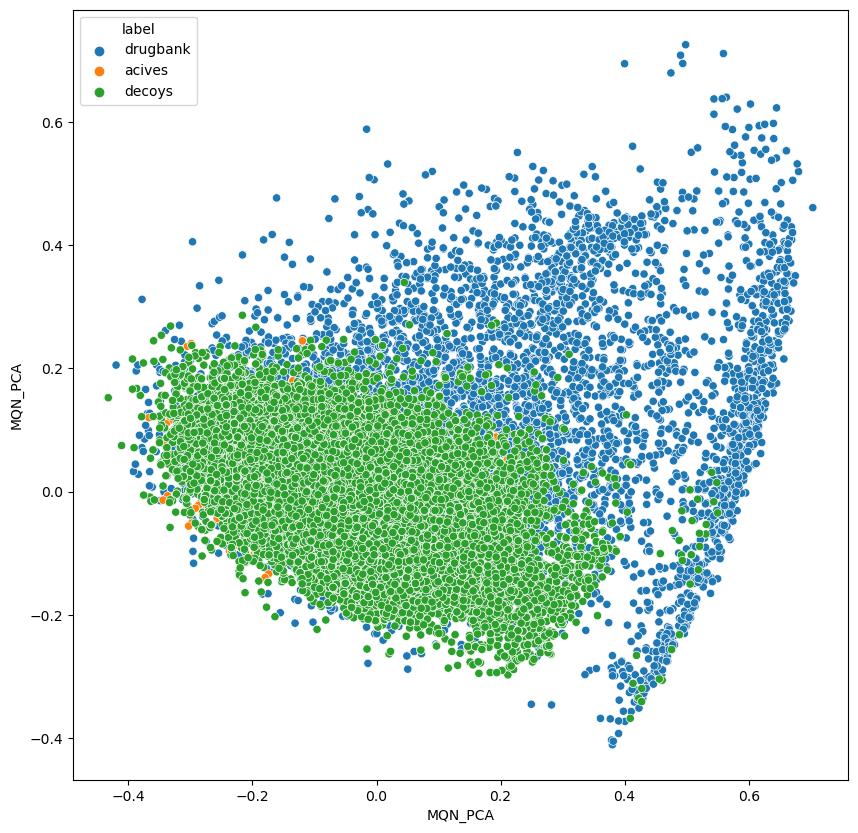

In [11]:
# apply PCA to MQN
pca = decomposition.PCA(n_components=2)
df['MQN_PCA'] = pca.fit_transform(df['MQN'].tolist()).tolist()

# plot PCA
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=df['MQN_PCA'].apply(lambda x: x[0]), y=df['MQN_PCA'].apply(lambda x: x[1]), hue=df['source'], ax=ax)
plt.show()

In [9]:
# using distance matrix apply t-SNE, MDS, UMAP

# t-SNE
clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(distance_matrix)
df = df.join(pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']))




In [13]:
df

,mol,label,smiles,MQN,MQN_PCA,tsne1,tsne2
0,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e21f0>,drugbank,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,"[0.3714333545134706, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4274310671733788, 0.052281400849564896]",-0.755748,31.516115
1,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e2260>,drugbank,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,"[0.3963035301363795, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.323321172776064, 0.05404809803571797]",-2.790232,31.741020
2,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e22d0>,drugbank,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,"[0.389076780551972, 0.0, 0.0, 0.0, 0.0, 0.0169...","[0.1810930471836665, 0.1738038570276524]",1.649184,33.770908
3,<rdkit.Chem.rdchem.Mol object at 0x7f4a7c1d9c40>,drugbank,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,"[0.42241551968646435, 0.0, 0.00603450742409234...","[0.31216122879701486, -0.010461897092347705]",-2.654538,30.344830
4,<rdkit.Chem.rdchem.Mol object at 0x7f4a320e2340>,drugbank,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,"[0.4566979076357256, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.21486167964816394, 0.09776584580587781]",6.855668,35.045441
...,...,...,...,...,...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9c40>,decoys,CCN(C)c1ccc(C(=O)Nc2ccc(CC(=O)NC(C)C)cc2)cc1,"[0.5157355060332316, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1405393256020522, -0.10630895279607862]",NaN,NaN
42178,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9cb0>,decoys,Cc1ccccc1CN(C)C(=O)CCCC[C@H]1SC[C@H]2NC(=O)N[C...,"[0.4843221048378526, 0.0, 0.0, 0.0, 0.0, 0.025...","[0.027419351678667655, 0.002866619420303789]",NaN,NaN
42179,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9d20>,decoys,CSc1ccc(CNC(=O)C(=O)Nc2ccc(OC(F)F)cc2)cc1,"[0.4498677054212187, 0.05292561240249631, 0.0,...","[0.15465715825853651, -0.05338587601380611]",NaN,NaN
42180,<rdkit.Chem.rdchem.Mol object at 0x7f49e66b9d90>,decoys,C[C@H](Cc1ccco1)NC(=O)C(=O)Nc1cccc(SC(F)F)c1,"[0.4403855060505443, 0.055048188256318034, 0.0...","[0.1659761537950866, -0.0481542568613432]",NaN,NaN


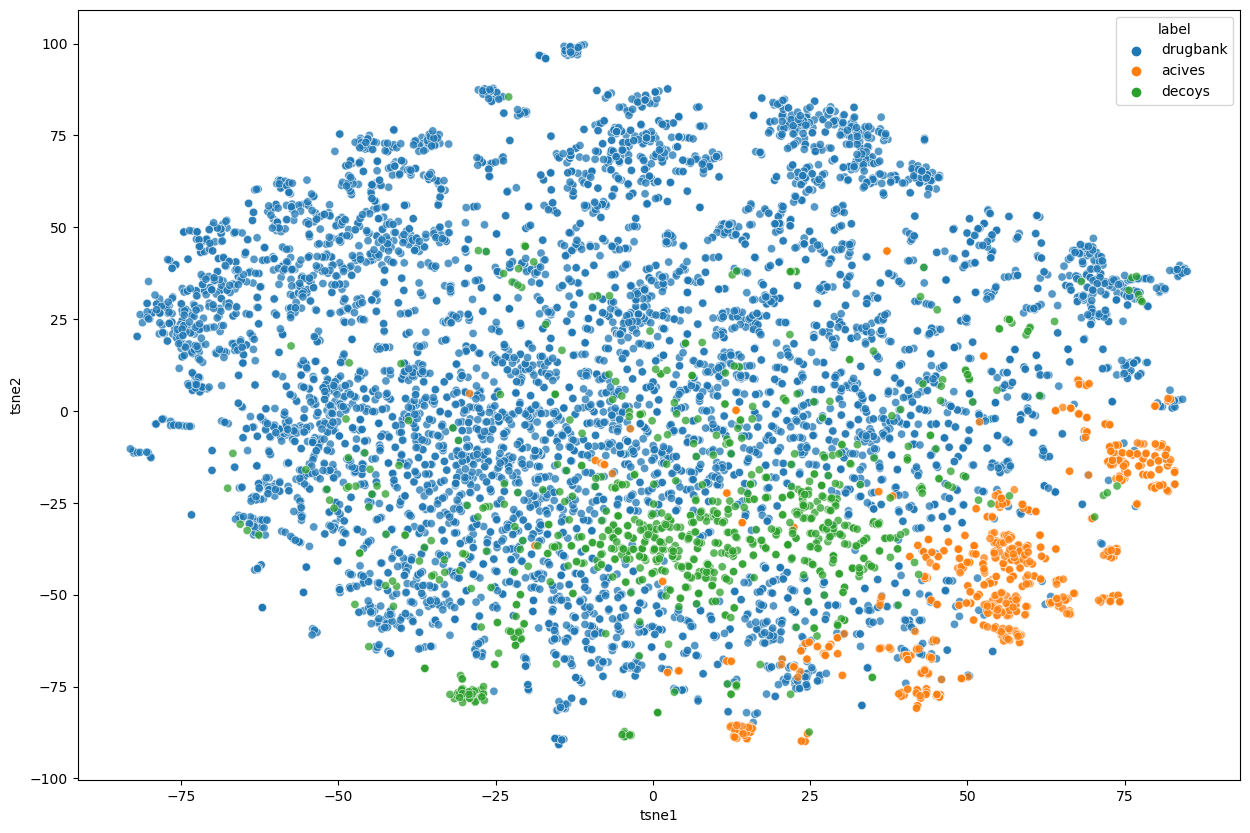

In [14]:

# plot t-SNE
fig, ax = plt.subplots(figsize=(15, 10))
p = sns.scatterplot(x='tsne1', y='tsne2', hue='source', data=df, ax=ax, alpha=0.75)


In [15]:
# UMAP
import umap
reducer = umap.UMAP(metric="precomputed")
embedding = reducer.fit_transform(distance_matrix)
df = df.join(pd.DataFrame(embedding, columns=['umap1', 'umap2']))


/home/dodo/anaconda3/envs/cdd/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


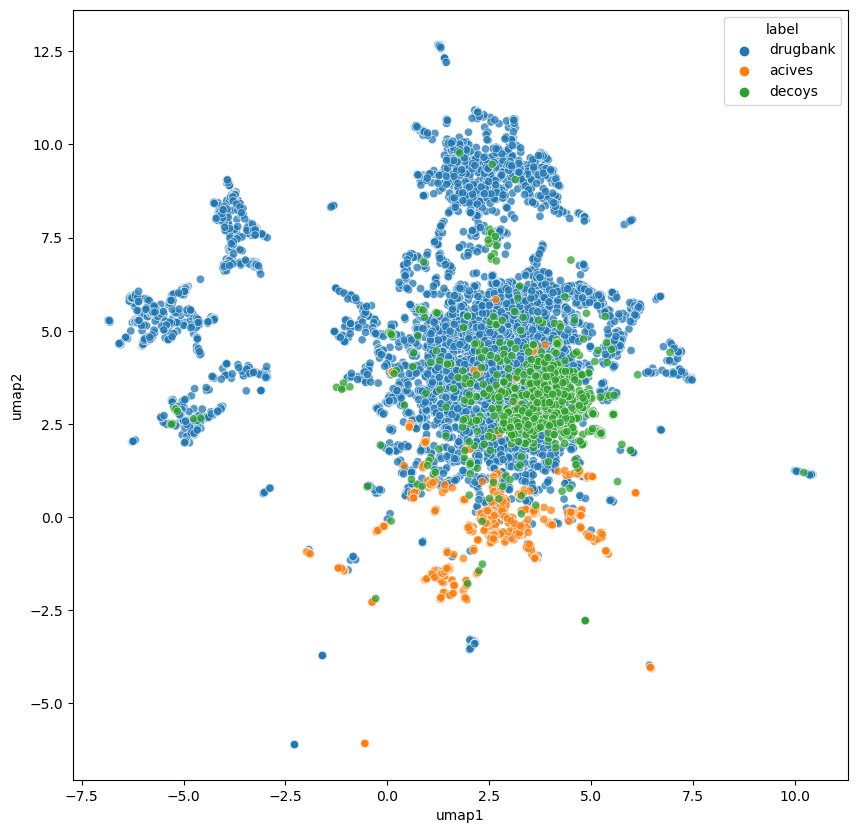

In [16]:

# plot UMAP
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='umap1', y='umap2', hue='source', data=df, ax=ax, alpha=0.75)
plt.show()

In [ ]:
# MDS
clf = manifold.MDS(n_components=2, dissimilarity="precomputed", n_init=1, max_iter=100)
X_mds = clf.fit_transform(distance_matrix)
df = df.join(pd.DataFrame(X_mds, columns=['mds1', 'mds2']))




In [ ]:
# plot MDS 


In [ ]:
# Hierarchical clustering on distance matrix using different linkage methods
